In [1]:
# Only for Colab, comment out if not using Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Change this line if you're using Colab to something like '/content/drive/MyDrive/TeamX/'
# where TeamX is just the clone of repository on your Google Drive
# and you have mounted the drive at /content/drive  
# See the Tutorial Slides for more detail.

# Works on your local machine but not on Colab!
PROJECT_ROOT = '../..' 

# Fix this path and use this one on Colab
# PROJECT_ROOT = '/content/drive/MyDrive/TeamX' 

In [3]:
import sys
from os.path import join as ospj

sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

## Playing around with the data
### 1. Load the data
Using the IIT-AFF dataset, we will load the data and see what it looks like.
### 2. Visualize the data
We will visualize the data to see what it looks like.
### 3. Preprocess the data
Create a DataLoaders object for the data.

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
import cv2


data_dir = ospj(PROJECT_ROOT, 'data', 'IIT_Affordances_2017', 'IIT_Affordances_2017')

background = (200, 222, 250)
c1 = (0,0,205)   
c2 = (34,139,34) 
c3 = (192,192,128)   
c4 = (165,42,42)    
c5 = (128,64,128)   
c6 = (204,102,0)  
c7 = (184,134,11) 
c8 = (0,153,153)
c9 = (0,134,141)
c10 = (184,0,141) 
c11 = (184,134,0) 
c12 = (184,134,223)
label_colours = np.array([background, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12])

# Object
col0 = (0, 0, 0)
col1 = (0, 255, 255)
col2 = (255, 0, 255)
col3 = (0, 125, 255)
col4 = (55, 125, 0)
col5 = (255, 50, 75)
col6 = (100, 100, 50)
col7 = (25, 234, 54)
col8 = (156, 65, 15)
col9 = (215, 25, 155)
col10 = (25, 25, 155)

col_map = [col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10]


# img = Image.open(ospj(data_dir, 'rgb', '00_00000090.jpg'))
# plt.imshow(img)

In [5]:
import math
print(math.sqrt(562500))

750.0


## Converting Text File to Segmentation Map

500
[375, 500]
375
(375, 500, 3)
(375, 500, 3)


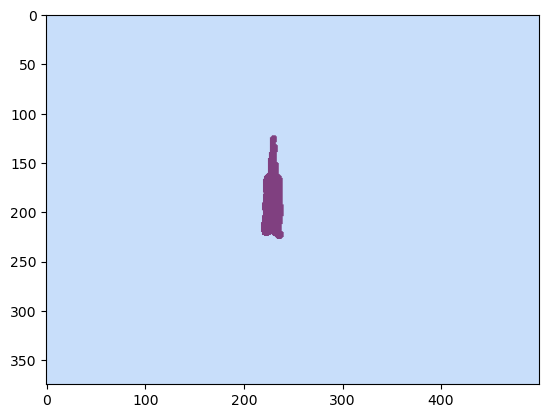

In [6]:
affordance_path = ospj(data_dir, 'affordances_labels', 'ILSVRC2014_train_00044663.txt')

with open(affordance_path) as f:
    affordance_labels = f.readlines()
    dim1 = len(affordance_labels)
    dim2 = len(affordance_labels[0].split())
    
count = 0

# Creation of Affordance pixel grid
# Checking image size to continue with creating Segmentation Map
affordance_pixels = []
for label in affordance_labels:
    row_pixels = []
    digits = label.split()
    count = 0
    for digit in digits:
        if digit.isdigit():
            row_pixels.append(digit)
            count += 1
    assert count==dim2, f"Actual count: {count}"
    affordance_pixels.append(row_pixels)
        
print(count)

dimensions = [dim1, dim2]
print(dimensions)

affordance_pixels = np.array(affordance_pixels, dtype=np.uint8)
print(len(affordance_pixels))

seg_map = label_colours[affordance_pixels]
print(seg_map.shape)

seg_map = np.array(seg_map, dtype=np.uint8)
print(seg_map.shape)

# bgr_image = cv2.cvtColor(seg_map, cv2.COLOR_RGB2BGR)

plt.imshow(seg_map)
plt.show()


Image shape: (375, 500, 3)
Mask shape: (375, 500, 3)


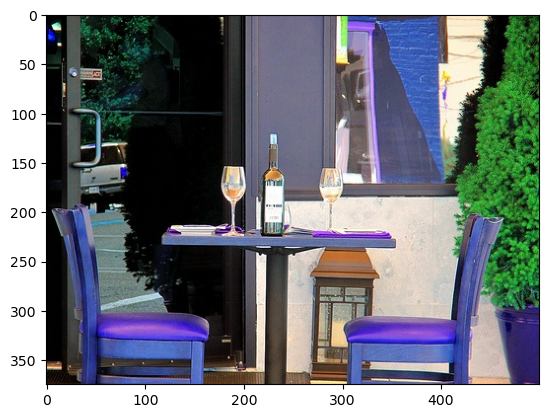

In [7]:
img_141 = cv2.imread(ospj(data_dir, 'rgb', 'ILSVRC2014_train_00044663.jpg'))
print(f"Image shape: {img_141.shape}")
print(f"Mask shape: {seg_map.shape}")
plt.imshow(img_141)
plt.show()

In [8]:
from transformers import SegformerFeatureExtractor, SegformerForImageClassification
from PIL import Image
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

seg_b0_feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
seg_b0_encoder_model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

# inputs = seg_b0_feature_extractor(images=img_141, segmentation_maps=seg_map, return_tensors="pt")

# print(inputs.keys())

# outputs = seg_b0_encoder_model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])


2023-07-29 16:52:53.883980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 16:52:55.091310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` inst

In [18]:
print(seg_b0_encoder_model)

SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   

In [11]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

seg_b0_processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
seg_b0_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

print(seg_b0_model)


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

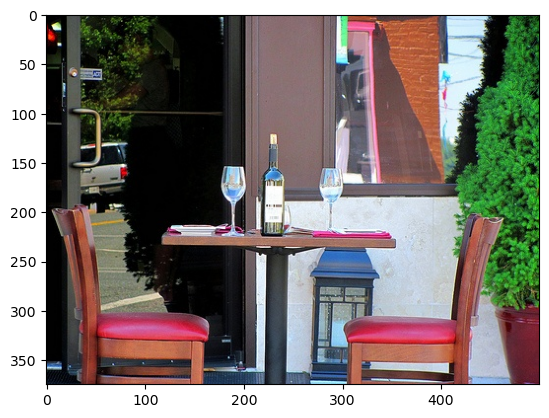

In [14]:
from PIL import Image

img = Image.open(ospj(data_dir, 'rgb', 'ILSVRC2014_train_00044663.jpg'))
plt.imshow(img)

In [10]:
inputs = processor_1(images=img_141, bgr_image, return_tensors="pt")
outputs = model_1(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

SyntaxError: positional argument follows keyword argument (1196143841.py, line 1)

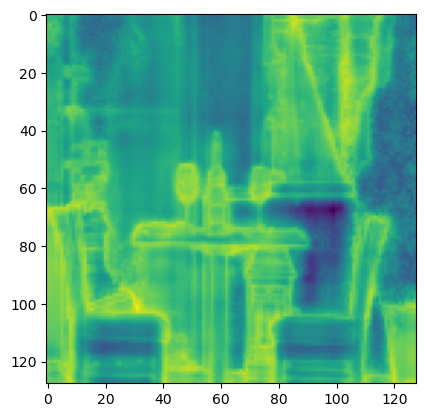

In [16]:
import numpy as np

plt.imshow(np.mean(logits.squeeze().detach().numpy(), axis=0))

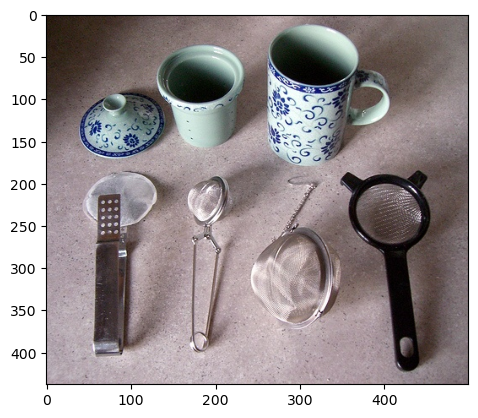

In [7]:
from PIL import Image
import matplotlib.pyplot as plt


data_dir = ospj(PROJECT_ROOT, 'data', 'VOCdevkit2012', 'VOC2012', 'JPEGImages')
img = Image.open(ospj(data_dir, '1347.jpg'))
plt.imshow(img)

In [4]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")



2023-07-27 00:20:17.777432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 00:20:19.294521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [8]:
inputs = image_processor(images=img, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([img.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )


Detected knife with confidence 0.887 at location [52.55, 209.57, 97.51, 406.44]
Detected cup with confidence 0.609 at location [46.0, 186.56, 132.97, 256.5]
Detected spoon with confidence 0.975 at location [167.58, 195.49, 220.04, 402.37]
Detected cup with confidence 0.958 at location [264.44, 11.85, 419.58, 180.63]
Detected dining table with confidence 0.838 at location [0.29, 0.4, 499.54, 432.73]
Detected cup with confidence 0.999 at location [129.92, 34.64, 240.35, 158.31]
Detected scissors with confidence 0.932 at location [359.01, 186.65, 465.91, 426.66]


In [9]:
print(results)

{'scores': tensor([0.8873, 0.6088, 0.9752, 0.9584, 0.8383, 0.9988, 0.9318],
       grad_fn=<IndexBackward0>), 'labels': tensor([49, 47, 50, 47, 67, 47, 87]), 'boxes': tensor([[5.2546e+01, 2.0957e+02, 9.7511e+01, 4.0644e+02],
        [4.5996e+01, 1.8656e+02, 1.3297e+02, 2.5650e+02],
        [1.6758e+02, 1.9549e+02, 2.2004e+02, 4.0237e+02],
        [2.6444e+02, 1.1853e+01, 4.1958e+02, 1.8063e+02],
        [2.8802e-01, 4.0177e-01, 4.9954e+02, 4.3273e+02],
        [1.2992e+02, 3.4641e+01, 2.4035e+02, 1.5831e+02],
        [3.5901e+02, 1.8665e+02, 4.6591e+02, 4.2666e+02]],
       grad_fn=<IndexBackward0>)}


In [23]:
from data_loaders.AffordanceDataset import AffordanceDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose, Resize



transform = Compose([Resize((256, 256)), 
                     ToTensor(), 
                     Normalize((0.5,), (0.5,))])

train_dataset = AffordanceDataset(root_dir=data_dir, 
                                  split_file="train_and_val.txt",
                                  feature_extractor=seg_b0_feature_extractor, 
                                  transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [24]:
count = 10
for batch in train_loader:
    count -= 1
    input = batch['image']
    target = batch['affordances_label']
    print(input.shape)
    print(target.shape)
    if count == 0:
        break

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/c/Users/Nirav/Documents/Saarland University/2023SoSe/HLCV/project/hlcv-project/src/notebooks/../../src/data_loaders/AffordanceDataset.py", line 121, in __getitem__
    encoded_input = self.feature_extractor(image, affordances_labels, return_tensors="pt")
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py", line 306, in __call__
    return super().__call__(images, segmentation_maps=segmentation_maps, **kwargs)
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/image_processing_utils.py", line 494, in __call__
    return self.preprocess(images, **kwargs)
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py", line 401, in preprocess
    images = [
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py", line 402, in <listcomp>
    self._preprocess_image(
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py", line 253, in _preprocess_image
    image = self._preprocess(
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py", line 227, in _preprocess
    image = self.resize(image=image, size=size, resample=resample)
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py", line 155, in resize
    return resize(
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/image_transforms.py", line 305, in resize
    do_rescale = _rescale_for_pil_conversion(image)
  File "/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/image_transforms.py", line 140, in _rescale_for_pil_conversion
    raise ValueError(
ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-1.0, 0.5529412031173706] which cannot be converted to uint8.
